In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import streamlit as st
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Ensure plots appear inline
%matplotlib inline

# Read datasets
movies = pd.read_csv('/Users/nandhinivijayakumar/Desktop/ADM/Project/tmdb_5000_movies.csv')
credits = pd.read_csv('/Users/nandhinivijayakumar/Desktop/ADM/Project/tmdb_5000_credits.csv')

# Merge datasets on the 'title' column
movies = movies.merge(credits, on='title')

# Initial dataset inspection
movies.info()
print(movies.isnull().sum())

# Selecting relevant columns
movies = movies[['movie_id', 'title', 'genres', 'original_language', 'release_date', 'overview', 'runtime', 'keywords', 'cast', 'crew', 'vote_average']]
movies.info()
print(movies.isnull().sum())

# Drop rows with missing data
movies.dropna(inplace=True)
print(movies.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

In [27]:

# Function to convert stringified lists to actual lists
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

# Apply conversion to 'genres' and 'keywords' columns
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)

# Function to take the top 3 cast members
def convert3(obj):
    L = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter != 3:
            L.append(i['name'])
            counter += 1
        else:
            break
    return L


In [28]:

# Apply the function to 'cast' column
movies['cast'] = movies['cast'].apply(convert3)

# Function to fetch the director from the 'crew' column
def fetch_director(obj):
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            return [i['name']]
    return []

# Apply the function to the 'crew' column
movies['crew'] = movies['crew'].apply(fetch_director)

# Combine all relevant text columns into a 'tags' column
def create_tags(row):
    return ' '.join(row['genres']) + ' ' + ' '.join(row['keywords']) + ' ' + ' '.join(row['cast']) + ' ' + ' '.join(row['crew']) + ' ' + row['overview']

movies['tags'] = movies.apply(create_tags, axis=1)

# Lowercase all tags for uniformity
movies['tags'] = movies['tags'].apply(lambda x: x.lower())

# Feature Engineering: Extract release year from release_date
movies['release_year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year

# Feature Engineering: Popularity based on vote average
movies['popularity'] = movies['vote_average'] * movies['runtime']  # Example popularity metric

# Initialize CountVectorizer
cv = CountVectorizer(max_features=5000, stop_words='english')

# Create a matrix of token counts
vectors = cv.fit_transform(movies['tags']).toarray()

# Compute cosine similarity
cosine_sim = cosine_similarity(vectors)

print(cosine_sim)



[[1.         0.06885304 0.04948717 ... 0.03142697 0.05410018 0.        ]
 [0.06885304 1.         0.04259177 ... 0.04057204 0.         0.        ]
 [0.04948717 0.04259177 1.         ... 0.01944039 0.08924215 0.        ]
 ...
 [0.03142697 0.04057204 0.01944039 ... 1.         0.06375767 0.03253   ]
 [0.05410018 0.         0.08924215 ... 0.06375767 1.         0.03733267]
 [0.         0.         0.         ... 0.03253    0.03733267 1.        ]]


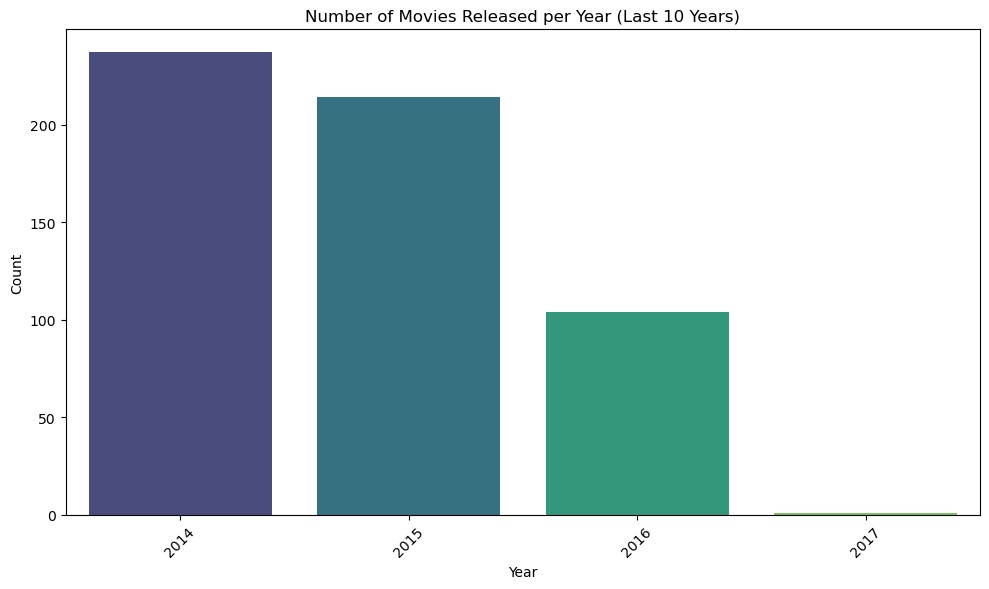

In [19]:


# 1. Number of Movies Released per Year (Last 10 Years)
current_year = pd.to_datetime('today').year
last_10_years = movies[movies['release_year'] >= current_year - 10]

plt.figure(figsize=(10, 6))
sns.countplot(data=last_10_years, x='release_year', palette='viridis')
plt.title("Number of Movies Released per Year (Last 10 Years)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



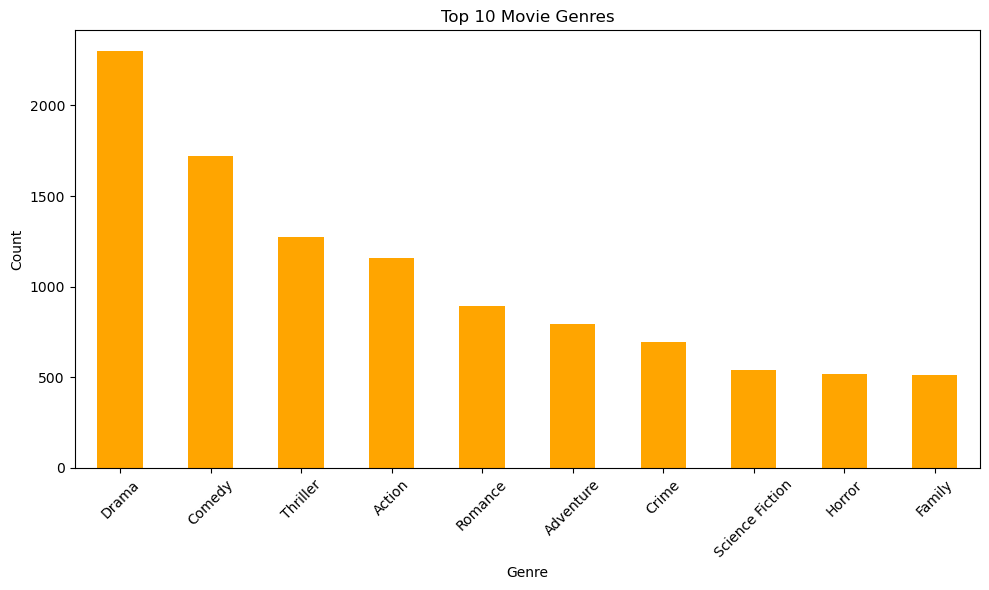

In [20]:
# 2. Movies per Genre (Top 10)
genre_counts = movies['genres'].explode().value_counts()

plt.figure(figsize=(10, 6))
genre_counts.head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



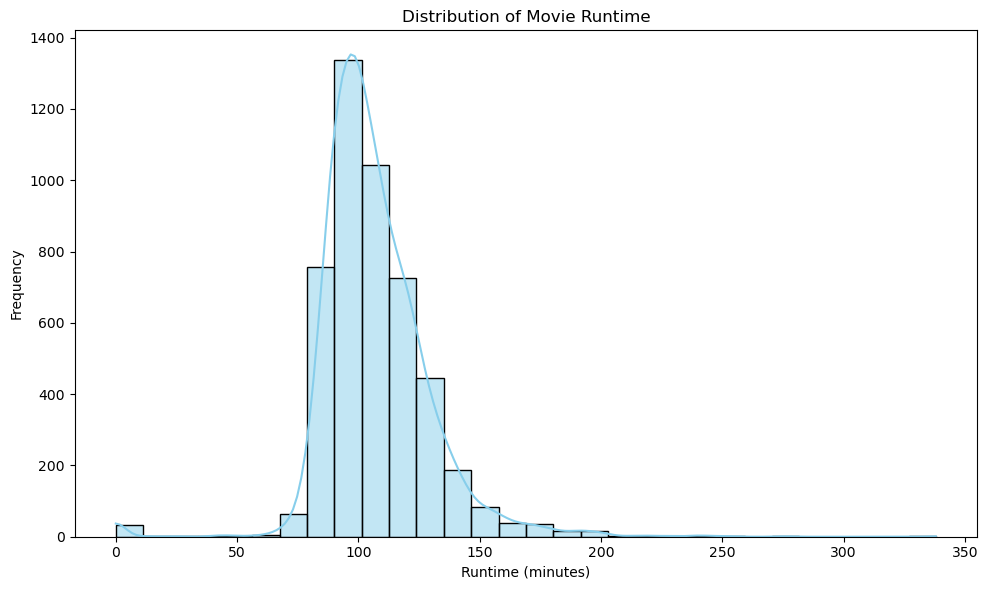

In [21]:
# 3. Distribution of Movie Runtime
plt.figure(figsize=(10, 6))
sns.histplot(movies['runtime'], bins=30, color='skyblue', kde=True)
plt.title("Distribution of Movie Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()




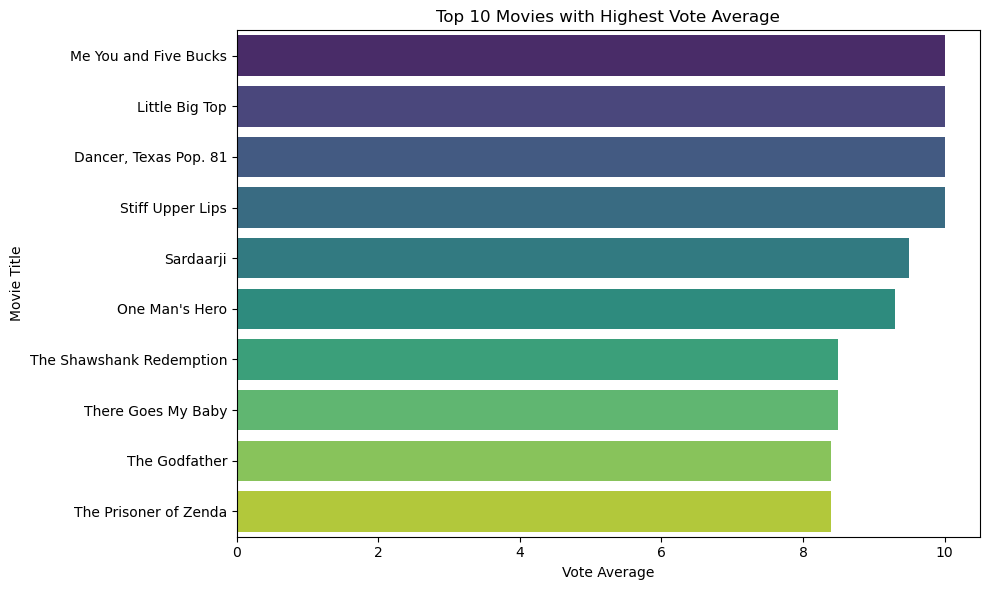

In [22]:
# 4. Top 10 Movies with the Highest Vote Average
top_movies = movies[['title', 'vote_average']].sort_values(by='vote_average', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_movies, x='vote_average', y='title', palette='viridis')
plt.title("Top 10 Movies with Highest Vote Average")
plt.xlabel("Vote Average")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before Streamlit section - Create the plot
genre_counts = movies['genres'].explode().value_counts()

plt.figure(figsize=(10, 6))
genre_counts.head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")

# Now in Streamlit section
import streamlit as st

# Display the plot
st.subheader("Movies per Genre")
st.pyplot(plt)

# Close the plot to avoid issues if you generate other plots later
plt.close()


2024-11-17 13:06:52.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:06:52.489 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:06:52.491 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:06:52.689 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:06:52.689 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [23]:
# Function to recommend movies based on similarity
def recommend(movie_title):
    # Get the index of the movie from the dataframe
    movie_index = movies[movies['title'] == movie_title].index[0]
    distances = cosine_sim[movie_index]
    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]  # Get top 5 similar movies
    
    recommendations = []
    for i in movie_list:
        recommendations.append(movies.iloc[i[0]].title)
    return recommendations

# Save the model and vectorizer using pickle
with open('/Users/nandhinivijayakumar/Desktop/ADM/Project/movie_recommendation_model.pkl', 'wb') as file:
    pickle.dump(cosine_sim, file)

with open('/Users/nandhinivijayakumar/Desktop/ADM/Project/count_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv, file)

print("Model and vectorizer saved successfully.")

# Streamlit app code
st.title("Movie Recommendation System")
st.write("Welcome to the movie recommendation app. Enter a movie title to get recommendations!")

# Create dropdown for movie selection
movie_input = st.selectbox("Select a movie:", movies['title'].head(50).tolist())  # Limit to first 50 movies



# Recommendation logic
if st.button("Get Recommendations"):
    if movie_input:
        try:
            recommendations = recommend(movie_input)
            st.write("Recommended movies:")
            for movie in recommendations:
                st.write(movie)
        except IndexError:
            st.write("Movie not found. Please check the spelling or try a different title.")
    else:
        st.write("Please select a movie to get recommendations.")

2024-11-17 13:10:43.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:10:43.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:10:43.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:10:43.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:10:43.174 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:10:43.174 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:10:43.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 13:10:43.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Model and vectorizer saved successfully.
